In [1]:
import numpy as np
import pandas as pd
import datetime as dt

data = pd.read_csv('SCADA-raw.csv', index_col='Timestamp', parse_dates=['Timestamp'])
data['Timestamp'] = data.index

stats = []
for column in data.columns:
    col_stats = [
        column,
        data[column].min(),
        data[column].max(),
        data[column].mean(),
        data[column].median()
    ]
    stats.append(col_stats)

stats_df = pd.DataFrame(stats, columns=['Column Name', 'Minimum', 'Maximum', 'Mean', 'Median'])

stats_df.to_csv('column_statistics.csv', index=False)

data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['Day'] = data['Timestamp'].dt.day
data['Hour'] = data['Timestamp'].dt.hour

data['Q-HSW_GPM'] = data['Q-HSW1_GPM']+data['Q-HSW2_GPM']

# Calculate hourly averages by grouping based on year, month, day, and nominal hour
hourly_averages = data.groupby(['Year', 'Month', 'Day', 'Hour'])['Biogas'].mean().reset_index()

data = pd.merge(data, hourly_averages, on=['Year', 'Month', 'Day', 'Hour'], how='left', suffixes=('', '_prev_hour_avg'))

data['hour_sin'] = np.sin(2 * np.pi * data['Hour']/24.0)
data['hour_cos'] = np.cos(2 * np.pi * data['Hour']/24.0)

data = data.drop(['Year','Month','Day','Hour'],axis=1)

data.set_index('Timestamp', inplace=True)
data.sort_index(inplace=True)
index = data.index
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='T')

data['DayOfWeek'] = data.index.weekday
data['day_sin'] = np.sin(2 * np.pi * data['DayOfWeek']/6.0)
data['day_cos'] = np.cos(2 * np.pi * data['DayOfWeek']/6.0)

# Reindex the DataFrame with the complete date range
data= data.reindex(date_range).rename_axis('Timestamp')
data = data.interpolate(method='time')
data['H-Dig1-deriv_FTpermin'] = data['H-Dig1_FT'].diff()
data['H-Dig2-deriv_FTpermin'] = data['H-Dig2_FT'].diff()

data['Biogas_prev_hour_avg'] = data['Biogas_prev_hour_avg'].shift(60)

# Calculate the time difference (in minutes) from midnight to the current time
def minutes_since_midnight(dt):
    midnight = dt.replace(hour=0, minute=0, second=0, microsecond=0)
    return (dt - midnight).seconds // 60

# Calculate the average of 'Biogas_burner' from midnight to the current time and reset at midnight
data['Biogas-burner_avg'] = data.groupby(data.index.date)['Biogas_burner'].transform(lambda x: x.expanding().mean())

# Calculate the 'V-burner_FT3-2' column by multiplying the minutes since midnight with the average
data['V-burner_FT3-2'] = data.index.map(minutes_since_midnight) * data['Biogas-burner_avg']

# Drop the temporary 'Biogas-burner_avg' column 
data.drop(columns=['Biogas-burner_avg'], inplace=True)

horizon = int(1440) 

data['Q-PS_MGD_prev_24h'] = data['Q-PS_MGD'].rolling(window=1440).mean()
data['Q-TWAS_GPM_prev_24h'] = data['Q-TWAS_GPM'].rolling(window=1440).mean()
data['Q-HSW_GPM_prev_24h'] = data['Q-HSW_GPM'].rolling(window=1440).mean()
data['Biogas_prev_24h'] = data['Biogas'].rolling(window=1440).mean()

data2 = data.copy()
data['Biogas_prev_24h_1'] = data2['Biogas_prev_24h'].shift(1440)
data['Biogas_prev_24h_2'] = data2['Biogas_prev_24h'].shift(2*1440)
data['Biogas_prev_24h_3'] = data2['Biogas_prev_24h'].shift(3*1440)
data['Biogas_prev_24h_4'] = data2['Biogas_prev_24h'].shift(4*1440)
data['Q-HSW_GPM_prev_24h_1']=data2['Q-HSW_GPM_prev_24h'].shift(1440)
data['Q-HSW_GPM_prev_24h_2']=data2['Q-HSW_GPM_prev_24h'].shift(2*1440)
data['Q-HSW_GPM_prev_24h_3']=data2['Q-HSW_GPM_prev_24h'].shift(3*1440)
data['Q-HSW_GPM_prev_24h_4']=data2['Q-HSW_GPM_prev_24h'].shift(4*1440)
data['Q-PS_MGD_prev_24h_1']=data2['Q-PS_MGD_prev_24h'].shift(1440)
data['Q-PS_MGD_prev_24h_2']=data2['Q-PS_MGD_prev_24h'].shift(2*1440)
data['Q-PS_MGD_prev_24h_3']=data2['Q-PS_MGD_prev_24h'].shift(3*1440)
data['Q-PS_MGD_prev_24h_4']=data2['Q-PS_MGD_prev_24h'].shift(4*1440)
data['Q-TWAS_GPM_prev_24h_1']=data2['Q-TWAS_GPM_prev_24h'].shift(1440)
data['Q-TWAS_GPM_prev_24h_2']=data2['Q-TWAS_GPM_prev_24h'].shift(2*1440)
data['Q-TWAS_GPM_prev_24h_3']=data2['Q-TWAS_GPM_prev_24h'].shift(3*1440)
data['Q-TWAS_GPM_prev_24h_4']=data2['Q-TWAS_GPM_prev_24h'].shift(4*1440)

data['Forecast'] = data['Biogas_prev_24h'].shift(-1*horizon)
data = data.drop(['Biogas'],axis=1)
data.dropna(inplace=True)

# Use .loc with the converted index to only select the rows that originally had valid data
data = data.loc[data.index.isin(index)]
data.head


<bound method NDFrame.head of                      D1_TEMPERATURE  D2_TEMPERATURE  Q-PS_MGD  Q-influent_MGD  \
Timestamp                                                                       
2022-03-23 00:00:00           95.50           96.70      0.08            4.60   
2022-03-23 00:01:00           95.59           96.87    314.37            4.71   
2022-03-23 00:02:00           95.43           96.71    308.00            5.04   
2022-03-23 00:03:00           95.57           96.81      0.08            3.59   
2022-03-23 00:04:00           95.50           96.74      0.08            3.50   
...                             ...             ...       ...             ...   
2023-02-27 20:00:00           94.19           93.55     34.68            3.62   
2023-02-27 20:01:00           94.11           93.57    222.74            3.48   
2023-02-27 20:02:00           94.15           93.64    191.81            3.21   
2023-02-27 20:03:00           94.13           93.56    203.25            2.93  

In [2]:
df = data.copy()

df.drop(columns=['DayOfWeek','Q-HSW1_GPM','Q-HSW2_GPM','V-burner_FT3','V-HSW-DIG2-yest_gal','Q-RAS_MGD','Q-RAS1_MGD', 'Q-RAS2_MGD', 'Q-RAS3_MGD', 'RAS-1-GATE_MGD', 'RAS-2-GATE_MGD', 'RAS-3-GATE_MGD','Q-WAS1_MGD','Q-WAS2_MGD','Q-Aeration_SCFM'], inplace=True)
print(df.columns)
df.head

Index(['D1_TEMPERATURE', 'D2_TEMPERATURE', 'Q-PS_MGD', 'Q-influent_MGD',
       'Q-TWAS_GPM', 'V-Boiler_FT3', 'H-HSW_ft', 'H-Dig1_FT', 'H-Dig2_FT',
       'Biogas_burner', 'Biogas_boiler', 'Q-HSW_GPM', 'Biogas_prev_hour_avg',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'H-Dig1-deriv_FTpermin',
       'H-Dig2-deriv_FTpermin', 'V-burner_FT3-2', 'Q-PS_MGD_prev_24h',
       'Q-TWAS_GPM_prev_24h', 'Q-HSW_GPM_prev_24h', 'Biogas_prev_24h',
       'Biogas_prev_24h_1', 'Biogas_prev_24h_2', 'Biogas_prev_24h_3',
       'Biogas_prev_24h_4', 'Q-HSW_GPM_prev_24h_1', 'Q-HSW_GPM_prev_24h_2',
       'Q-HSW_GPM_prev_24h_3', 'Q-HSW_GPM_prev_24h_4', 'Q-PS_MGD_prev_24h_1',
       'Q-PS_MGD_prev_24h_2', 'Q-PS_MGD_prev_24h_3', 'Q-PS_MGD_prev_24h_4',
       'Q-TWAS_GPM_prev_24h_1', 'Q-TWAS_GPM_prev_24h_2',
       'Q-TWAS_GPM_prev_24h_3', 'Q-TWAS_GPM_prev_24h_4', 'Forecast'],
      dtype='object')


<bound method NDFrame.head of                      D1_TEMPERATURE  D2_TEMPERATURE  Q-PS_MGD  Q-influent_MGD  \
Timestamp                                                                       
2022-03-23 00:00:00           95.50           96.70      0.08            4.60   
2022-03-23 00:01:00           95.59           96.87    314.37            4.71   
2022-03-23 00:02:00           95.43           96.71    308.00            5.04   
2022-03-23 00:03:00           95.57           96.81      0.08            3.59   
2022-03-23 00:04:00           95.50           96.74      0.08            3.50   
...                             ...             ...       ...             ...   
2023-02-27 20:00:00           94.19           93.55     34.68            3.62   
2023-02-27 20:01:00           94.11           93.57    222.74            3.48   
2023-02-27 20:02:00           94.15           93.64    191.81            3.21   
2023-02-27 20:03:00           94.13           93.56    203.25            2.93  

array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Times

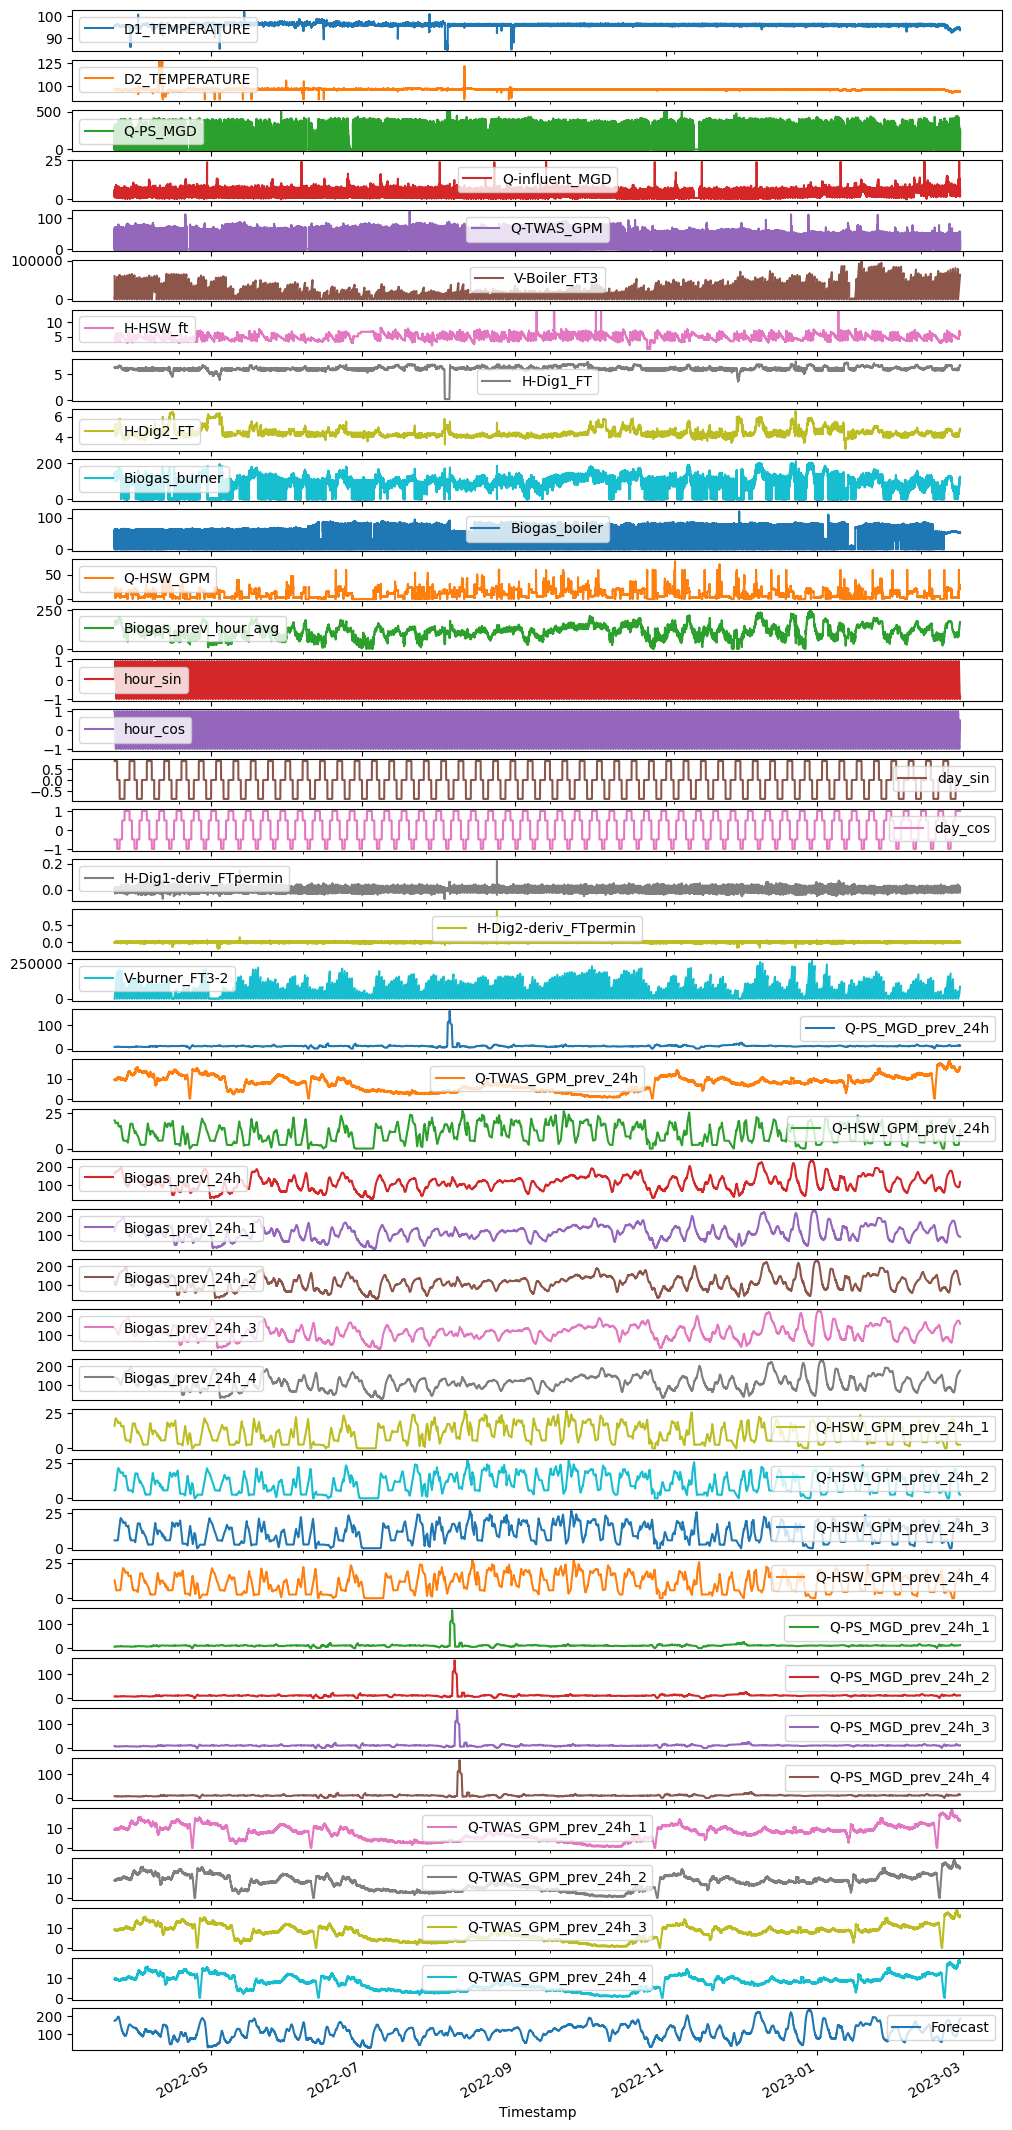

In [3]:
df.plot(subplots=True, figsize=(12, 30))

In [4]:
import pandas as pd

#remove lid height derivative due to erroneously high values
index_to_remove = '2022-08-24 14:09'
new_value = 0  #median of derivatives

# Update the value at the specified index
df.at[index_to_remove, 'H-Dig1-deriv_FTpermin'] = new_value
df.at[index_to_remove, 'H-Dig2-deriv_FTpermin'] = new_value


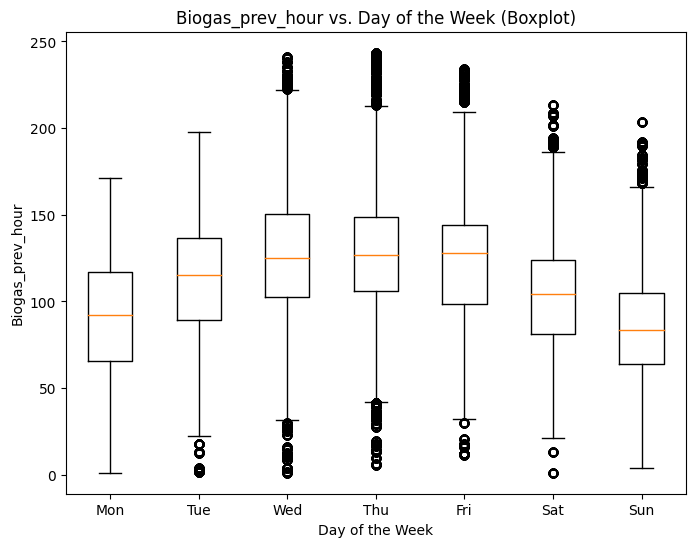

In [5]:
import matplotlib.pyplot as plt
df['Biogas_prev_hour_avg'] = pd.to_numeric(df['Biogas_prev_hour_avg'], errors='coerce')  # Force 'Biogas' column to numeric

# Specify the desired time period
start_date = pd.Timestamp('2022-04-01')
end_date = pd.Timestamp('2023-01-01')

# Filter the "Biogas" data within the specified time period
filtered_data = df.loc[start_date:end_date, 'Biogas_prev_hour_avg']

# Group the data by day of the week and keep the index as the day of the week
daily_data = filtered_data.groupby(filtered_data.index.dayofweek, group_keys=False)  

# Create a new DataFrame with the daily data
daily_df = pd.DataFrame({'Biogas_prev_hour_avg': daily_data.apply(list)})

# Plot the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(daily_df['Biogas_prev_hour_avg'].values)
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # Set x-ticks to represent each day of the week
plt.xlabel('Day of the Week')
plt.ylabel('Biogas_prev_hour')
plt.title('Biogas_prev_hour vs. Day of the Week (Boxplot)')
plt.show()

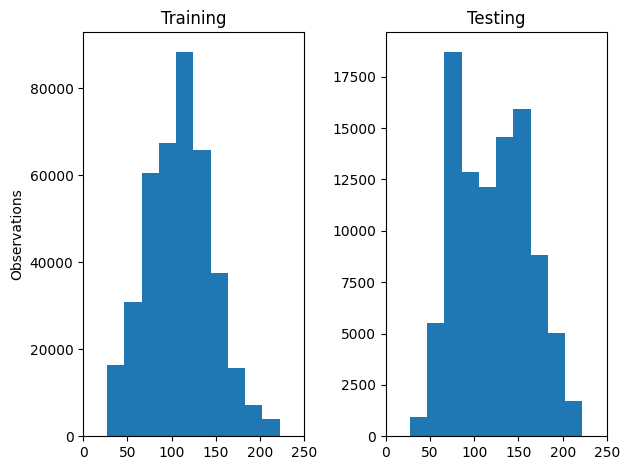

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('Forecast', axis=1), df['Forecast'], test_size=0.2,
    shuffle=False)

fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)

# Set common x and y axis limits
common_xlim = (0, 250)

# Plot the histograms
hist1, bins1, _ = axs[0].hist(y_train, bins=10)
axs[0].set_xlim(common_xlim)
axs[0].set_ylabel('Observations')
axs[0].set_title('Training')

axs[1].hist(y_test, bins=bins1)
axs[1].set_xlim(common_xlim)
axs[1].set_title('Testing')

plt.show()

In [7]:
# Find the indices of NaN values
nan_indices = np.where(df.isna())

# Print the coordinates of each NaN value
for row, col in zip(nan_indices[0], nan_indices[1]):
    print(f"NaN value found at coordinates: (row={row}, column={col})")


In [8]:
df.to_csv("SCADA-FINAL.csv", index=True)

In [9]:
df.shape

(491761, 41)